In [1]:
import torch, torchvision
print(torch.__version__, torchvision.__version__)

2.5.1+cu121 0.20.1+cu121


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ky8a5dee
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ky8a5dee
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6361714 sha256=e43371011640c79970a0ed39d4e80165e0c48571c3ffc3a7c429bc898a72dda5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnq27y5x/wheels/47/e5/15/94c80df2ba85500c5

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from PIL import Image
import os
import json
import numpy as np
import shutil
import random
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode

import matplotlib.pyplot as plt

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file, get_checkpoint_url

In [4]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.


In [5]:
annotations_file = "/kaggle/input/building-instance-annotation/corrected_annotation.json"

dataset_path = "/kaggle/input/synthetic-word-ocr/train/images"

In [6]:
output_dir = "/kaggle/working/output"

In [7]:
with open(annotations_file, "r") as f:
    building_data = json.load(f)

In [8]:
building_data.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [9]:
image_ids = [img["id"] for img in building_data["images"]]
random.shuffle(image_ids)

In [10]:

# Split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8  

# Split image IDs into train and test sets
split_idx = int(len(image_ids) * split_ratio)
train_ids = set(image_ids[:split_idx])
test_ids = set(image_ids[split_idx:])

In [11]:
# Separate images and annotations
def filter_coco_data(image_ids, data):
    """Filter images and annotations based on image IDs."""
    images = [img for img in data["images"] if img["id"] in image_ids]
    annotations = [ann for ann in data["annotations"] if ann["image_id"] in image_ids]
    return {"info": data["info"], "categories": data["categories"], "images": images, "annotations": annotations}


In [12]:
train_building = filter_coco_data(train_ids, building_data)
test_building = filter_coco_data(test_ids, building_data)

In [13]:
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, "train.json"), "w") as f:
    json.dump(train_building, f, indent=4)
with open(os.path.join(output_dir, "test.json"), "w") as f:
    json.dump(test_building, f, indent=4)

In [14]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("building_train", {}, "/kaggle/working/output/train.json", "/kaggle/input/synthetic-word-ocr/train/images")
register_coco_instances("building_val", {}, "/kaggle/working/output/test.json", "/kaggle/input/synthetic-word-ocr/train/images")

In [15]:
building_metadata = MetadataCatalog.get("building_train")

In [16]:
train_building = DatasetCatalog.get("building_train")  # This should return a list

In [17]:
test_building_metadata = MetadataCatalog.get("building_val")
test_building = DatasetCatalog.get("building_val")

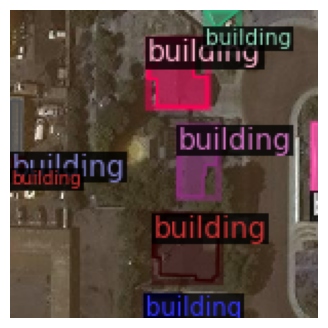

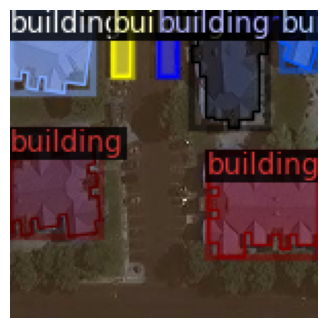

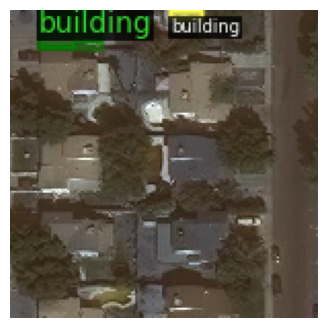

In [18]:
for d in random.sample(train_building, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=building_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(4,4))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")  # Hide axes
    plt.show()

In [19]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file, get_checkpoint_url

In [20]:
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("building_train",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.WEIGHTS = get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
# cfg.SOLVER.CHECKPOINT_PERIOD = 50
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "weights/resnext101"
cfg.INPUT.MASK_FORMAT = 'bitmask'

In [21]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

model_final_2d9806.pkl: 431MB [00:01, 222MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/kaggle/working/weights/resnext101/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

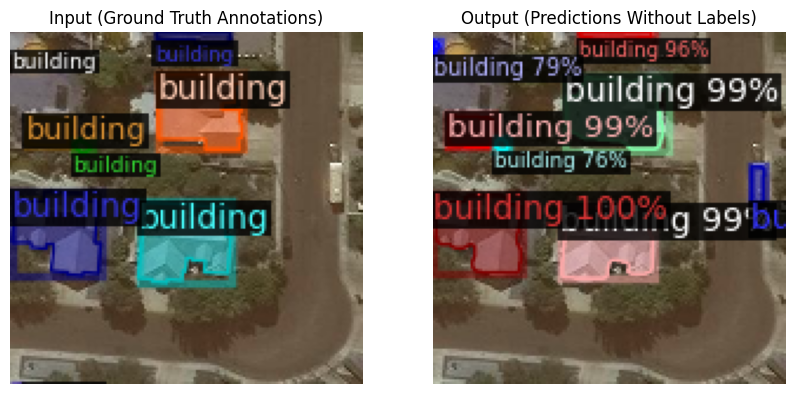

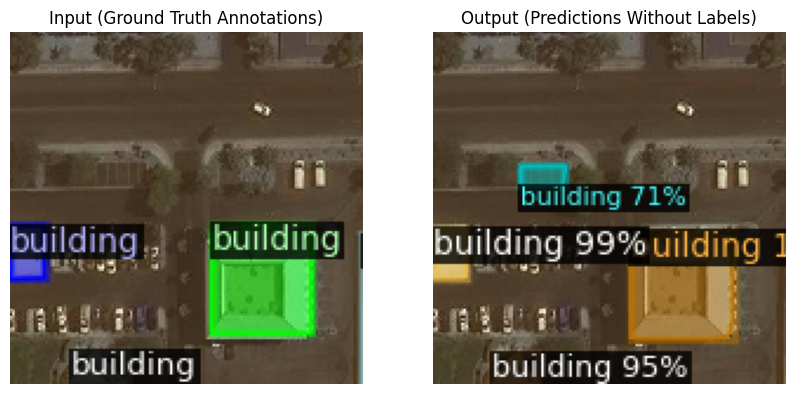

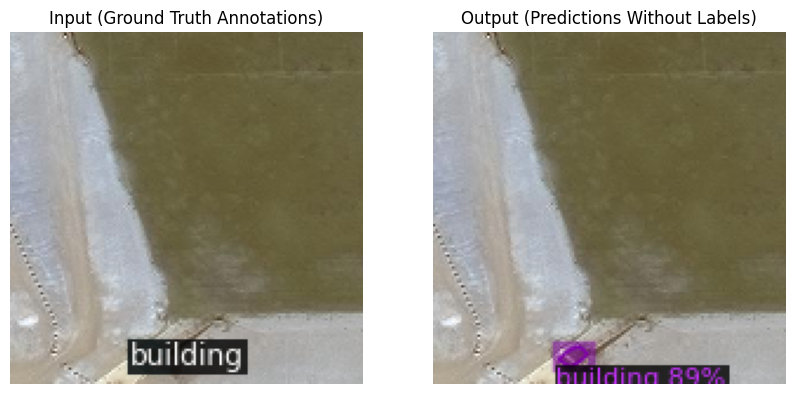

In [23]:
class CustomVisualizer(Visualizer):
    def _create_text_labels(self, classes, scores, class_names, is_crowd=None):
        return None  
for d in random.sample(train_building, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # Get model predictions
    
    # Visualize the input image with ground truth annotations
    v_input = CustomVisualizer(im[:, :, ::-1], metadata=building_metadata, scale=0.5)
    input_image = v_input.draw_dataset_dict(d)  # Ground truth annotations

    # Visualize the predicted output (without labels)
    v_output = CustomVisualizer(im[:, :, ::-1], metadata=building_metadata, scale=0.5)
    instances = outputs["instances"].to("cpu")
    out = v_output.draw_instance_predictions(instances)  # Predictions without labels
    
    # Display both images side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    ax[0].imshow(input_image.get_image()[:, :, ::-1])
    ax[0].axis("off")  # Hide axis
    ax[0].set_title("Input (Ground Truth Annotations)")

    ax[1].imshow(out.get_image()[:, :, ::-1])
    ax[1].axis("off")
    ax[1].set_title("Output (Predictions Without Labels)")

    plt.show()

In [24]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("building_val", output_dir="/kaggle/working/output")
val_loader = build_detection_test_loader(cfg, "building_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

Loading and preparing results...
DONE (t=0.57s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.784
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.